In [26]:
import os
import numpy as np

from keras.preprocessing.image import ImageDataGenerator
from keras_preprocessing.image import load_img, img_to_array

import warnings 
warnings.filterwarnings('ignore')

In [4]:
base_dir = '/Users/oscar/Downloads/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [10]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

2023-06-27 23:24:38.810986: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [12]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary'
    )
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features , labels

In [13]:
train_features , train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features , test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
1/1 [==============================] - 3s 3s/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 3s 3s/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 3s 3s/step


In [14]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [15]:
from keras import models 
from keras import layers
from keras import optimizers

model = models.Sequential()

model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

In [17]:
model.compile(
    optimizer=optimizers.RMSprop(lr=2e-5),
    loss='binary_crossentropy',
    metrics=['acc']
)

In [18]:
history = model.fit(
    train_features, train_labels,
    epochs=30,
    batch_size=20,
    validation_data=(validation_features, validation_labels)
)

Epoch 1/30
100/100 [==============================] - 4s 28ms/step - loss: 0.5493 - acc: 0.7235 - val_loss: 0.4218 - val_acc: 0.8470
Epoch 2/30
100/100 [==============================] - 3s 28ms/step - loss: 0.3789 - acc: 0.8510 - val_loss: 0.3438 - val_acc: 0.8690
Epoch 3/30
100/100 [==============================] - 3s 30ms/step - loss: 0.3157 - acc: 0.8725 - val_loss: 0.3051 - val_acc: 0.8780
Epoch 4/30
100/100 [==============================] - 2s 23ms/step - loss: 0.2746 - acc: 0.8925 - val_loss: 0.2843 - val_acc: 0.8910
Epoch 5/30
100/100 [==============================] - 3s 29ms/step - loss: 0.2429 - acc: 0.9090 - val_loss: 0.2698 - val_acc: 0.8920
Epoch 6/30
100/100 [==============================] - 3s 27ms/step - loss: 0.2237 - acc: 0.9245 - val_loss: 0.2606 - val_acc: 0.8970
Epoch 7/30
100/100 [==============================] - 3s 33ms/step - loss: 0.2069 - acc: 0.9295 - val_loss: 0.2654 - val_acc: 0.8910
Epoch 8/30
100/100 [==============================] - 2s 24ms/step - 

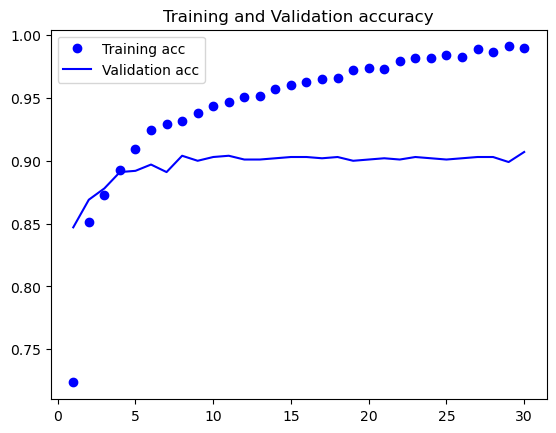

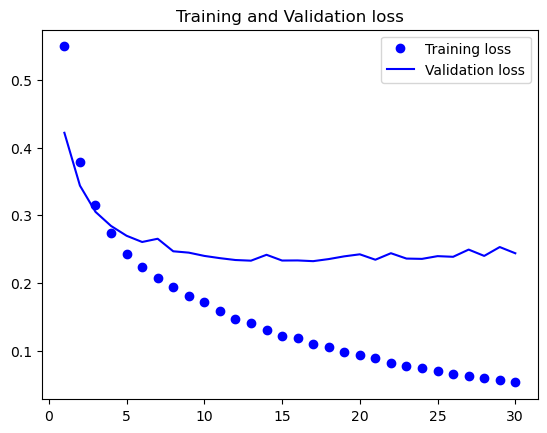

In [19]:
import matplotlib.pyplot as plt 

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [20]:
model.save('cats_vs_dogs_small_VGG16_v3.h5')

In [21]:
import tensorflow as tf
from tensorflow import keras

# Load the Keras model
model = keras.models.load_model('cats_vs_dogs_small_VGG16_v3.h5')

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('cats_vs_dogs_small_v2.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/5k/1gm98l3s7l541jt9yyg0qb6w0000gn/T/tmpw335fzvz/assets


2023-06-27 23:47:31.035289: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-06-27 23:47:31.036481: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-06-27 23:47:31.043612: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/5k/1gm98l3s7l541jt9yyg0qb6w0000gn/T/tmpw335fzvz
2023-06-27 23:47:31.050158: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-06-27 23:47:31.050461: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /var/folders/5k/1gm98l3s7l541jt9yyg0qb6w0000gn/T/tmpw335fzvz
2023-06-27 23:47:31.059215: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2023-06-27 23:47:31.060909: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-06-27 23:47:31.166672: I tensorflow/cc/saved_model/loader.

In [29]:
from PIL import Image
from matplotlib import image

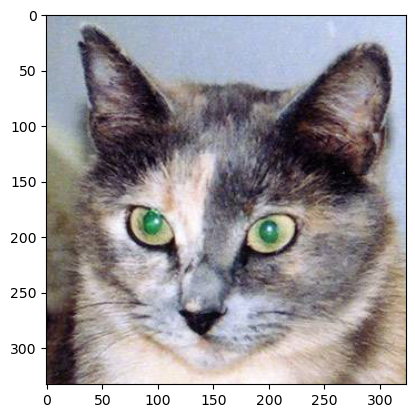

In [30]:
image_normal=image.imread('/Users/oscar/Downloads/cats_and_dogs_small/test/cats/cat.1700.jpg')
plt.imshow(image_normal)

In [38]:
from keras.applications.vgg16 import preprocess_input

In [39]:
def predict_cat_dog(img,model_name):
    # load the model
    model = keras.models.load_model(model_name)
    # load and prepare the image
    img = load_img(img,target_size=(150,150))
    # convert to array
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    # preprocess the image
    img_data=preprocess_input(x)
    # predict the class
    classes=model.predict(img_data)
    result=int(classes[0][0])
    if result==0:
        print("It's a Cat")
        plt.imshow(load_img('/Users/oscar/Downloads/cats_and_dogs_small/test/cats/cat.1700.jpg',target_size=(150,150)))
    else:
        print("It's a Dog")
        plt.imshow(load_img('/Users/oscar/Downloads/cats_and_dogs_small/test/cats/cat.1700.jpg',target_size=(150,150)))

In [40]:
model = keras.models.load_model('cats_vs_dogs_small_VGG16_v3.h5')

In [41]:
predict_cat_dog('/Users/oscar/Downloads/cats_and_dogs_small/test/cats/cat.1700.jpg',model_name='cats_vs_dogs_small_VGG16_v3.h5')

ValueError: in user code:

    File "/Users/oscar/opt/anaconda3/envs/data/lib/python3.9/site-packages/keras/engine/training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "/Users/oscar/opt/anaconda3/envs/data/lib/python3.9/site-packages/keras/engine/training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/oscar/opt/anaconda3/envs/data/lib/python3.9/site-packages/keras/engine/training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/oscar/opt/anaconda3/envs/data/lib/python3.9/site-packages/keras/engine/training.py", line 1983, in predict_step
        return self(x, training=False)
    File "/Users/oscar/opt/anaconda3/envs/data/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/oscar/opt/anaconda3/envs/data/lib/python3.9/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 8192), found shape=(None, 150, 150, 3)
